transfer learning between a 1Dgamma and a 1Dgamma function with fixed parameters.
The initial parameters are chosen in the range (0,2*pi)

### 4 free parameters (6 fixed parameters)

In [1]:
from scipy.special import kl_div,rel_entr
import numpy as np
from matplotlib import pyplot
import quantum_classical_1Dgamma as qc

import tensorflow as tf
from matplotlib import pyplot
from qibo import gates, hamiltonians, models, set_backend, set_threads

[Qibo 0.1.6|INFO|2022-03-28 11:34:37]: Using numpy backend on /CPU:0
[Qibo 0.1.6|WARNING|2022-03-28 11:34:37]: numpy backend uses `np.einsum` and supports CPU only. Consider installing the qibojit or qibotf backends for increased performance and to enable GPU acceleration.
[Qibo 0.1.6|INFO|2022-03-28 11:34:38]: Using tensorflow backend on /device:CPU:0
[Qibo 0.1.6|WARNING|2022-03-28 11:34:38]: `set_threads` is not supported by the tensorflow backend. Please use tensorflow's thread setters: `tf.config.threading.set_inter_op_parallelism_threads` or `tf.config.threading.set_intra_op_parallelism_threads` to switch the number of threads.


In [2]:
# functions

def kl_divergence(bins_real, bins_fake,epsilon):
    
    epsilon=0.1
    prob_real=[]
    prob_fake=[]
    for i in range (len(bins_real)):
        prob_real.append(bins_real[i]+epsilon)
        prob_fake.append(epsilon+bins_fake[i])

    #print(prob_fake,prob_real)  

    prob_real=prob_real/sum(prob_real) # probability for each bin (Normalization)
    prob_fake=prob_fake/sum(prob_fake)

   
    return sum(prob_real[i] * np.log(prob_real[i]/prob_fake[i]) for i in range(len(prob_real)))# Convergence problem if a[i] or b[i] equals zero. 
                                                            #I add a little quantity to each bin to avoid problems


def hamiltonian1():
        m0 = hamiltonians.Z(1).matrix
        ham = hamiltonians.Hamiltonian(1, m0)
        return ham


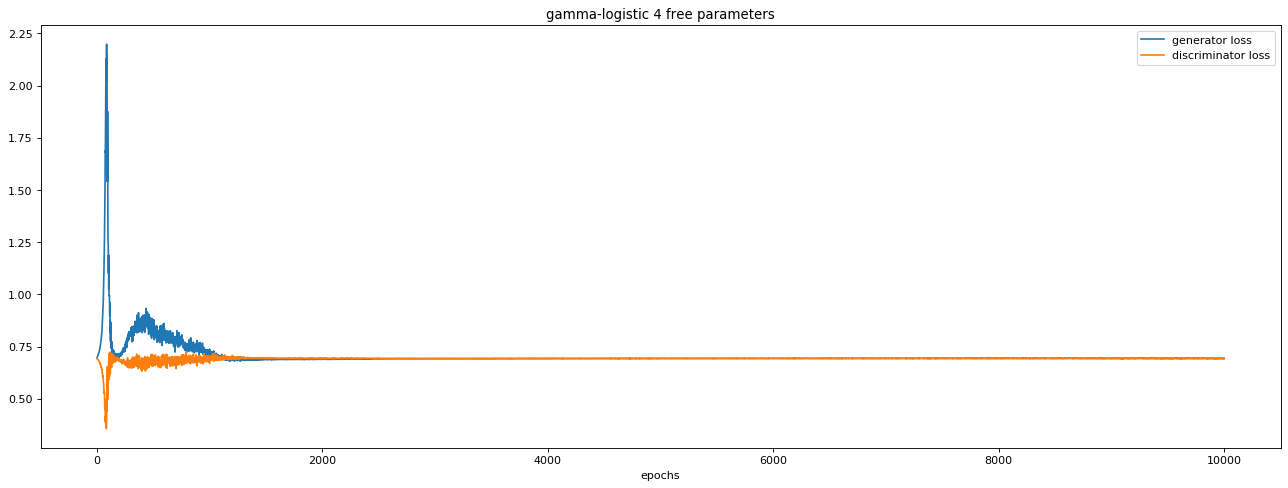

In [12]:
n_layers=128
d_loss = np.loadtxt(f"dloss_1Dgamma_1_3_2_10000_{n_layers}_0.1_fixed_params_6", delimiter=' ')
g_loss= np.loadtxt(f"gloss_1Dgamma_1_3_2_10000_{n_layers}_0.1_fixed_params_6", delimiter=' ')
d_loss=d_loss[:10000]
g_loss=g_loss[:10000]
pyplot.figure(figsize=(20, 7), dpi=80)
pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), g_loss, label='generator loss')
pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), d_loss, label='discriminator loss')
pyplot.title('gamma-logistic 4 free parameters')
pyplot.xlabel('epochs')
pyplot.legend()

pyplot.show()


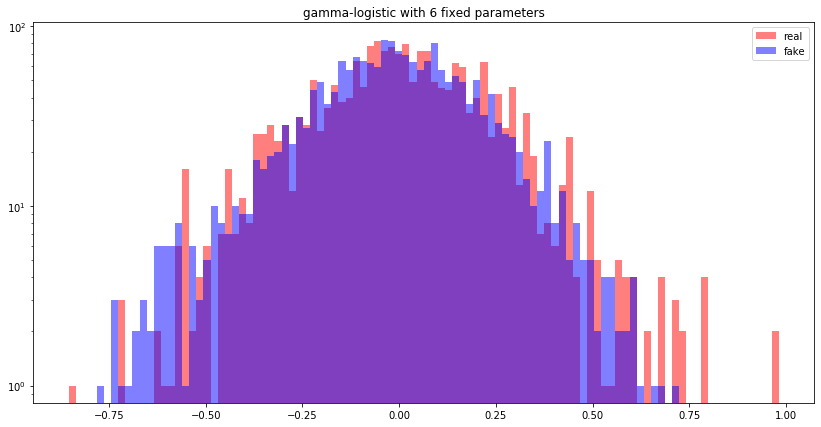

In [16]:
# number of qubits generator
nqubits = 1
# create hamiltonians
def hamiltonian1():
        m0 = hamiltonians.Z(1).matrix
        ham = hamiltonians.Hamiltonian(1, m0)
        return ham
hamiltonian1 = hamiltonian1()

latent_dim=3
samples=2000
nqubits=1
layers=2
# create quantum generator
circuit = models.Circuit(nqubits)
for l in range(layers):
    for q in range(nqubits):
        circuit.add(gates.RY(q, 0))
        circuit.add(gates.RZ(q, 0))
for q in range(nqubits):
    circuit.add(gates.RY(q, 0))  

params = np.loadtxt(f"PARAMS_1Dgamma_1_3_2_10000_{n_layers}_0.1_fixed_params_6", delimiter=' ', unpack='true')
params = tf.Variable(params)
#print(params)
x_fake, y_fake = qc.generate_fake_samples(params, latent_dim, samples, circuit, nqubits, layers, hamiltonian1)
#x_fake,_= qc2.generate_fake_samples(params, latent_dim, samples)
s=qc.generate_training_real_samples(samples)
x_real, y_real = qc.generate_real_samples(samples, s, 1000)

nbins=100
pyplot.figure(figsize=(14, 7))
bins_real=pyplot.hist(x_real, color='red', bins=nbins,label='real', alpha=0.5)
bins_fake=pyplot.hist(x_fake.numpy(), bins=bins_real[1],color='blue', label='fake', alpha=0.5)
#pyplot.xlim(-1,1)
pyplot.yscale('log')
pyplot.title('gamma-logistic with 6 fixed parameters')
pyplot.legend()
pyplot.show()

In [17]:
#print(prob_fake,prob_real)
print("KL DIVERGENCE:",kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1))

KL DIVERGENCE: 0.11426118206104398


### 6 free parameters (4 fixed parameters)

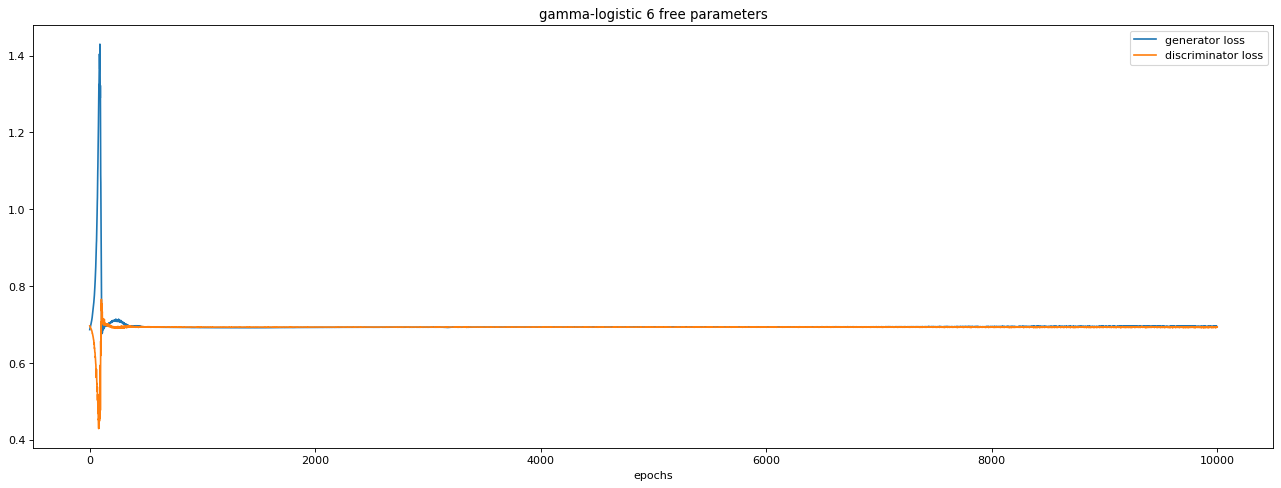

In [11]:
n_layers=128
d_loss = np.loadtxt(f"dloss_1Dgamma_1_3_2_10000_{n_layers}_0.1_fixed_params_4", delimiter=' ')
g_loss= np.loadtxt(f"gloss_1Dgamma_1_3_2_10000_{n_layers}_0.1_fixed_params_4", delimiter=' ')
g_loss=g_loss[:10000]
d_loss=d_loss[:10000]
pyplot.figure(figsize=(20, 7), dpi=80)
pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), g_loss, label='generator loss')
pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), d_loss, label='discriminator loss')
pyplot.title('gamma-logistic 6 free parameters')
pyplot.xlabel('epochs')
pyplot.legend()

pyplot.show()


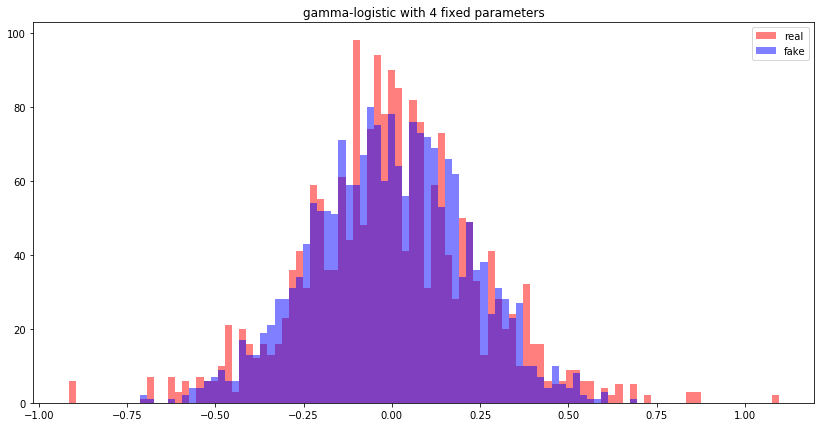

In [6]:
# number of qubits generator
nqubits = 1
# create hamiltonians
def hamiltonian1():
        m0 = hamiltonians.Z(1).matrix
        ham = hamiltonians.Hamiltonian(1, m0)
        return ham
hamiltonian1 = hamiltonian1()

latent_dim=3
samples=2000
nqubits=1
layers=2
# create quantum generator
circuit = models.Circuit(nqubits)
for l in range(layers):
    for q in range(nqubits):
        circuit.add(gates.RY(q, 0))
        circuit.add(gates.RZ(q, 0))
for q in range(nqubits):
    circuit.add(gates.RY(q, 0))  

params = np.loadtxt(f"PARAMS_1Dgamma_1_3_2_10000_{n_layers}_0.1_fixed_params_4", delimiter=' ', unpack='true')
params = tf.Variable(params)
#print(params)
x_fake, y_fake = qc.generate_fake_samples(params, latent_dim, samples, circuit, nqubits, layers, hamiltonian1)
#x_fake,_= qc2.generate_fake_samples(params, latent_dim, samples)
s=qc.generate_training_real_samples(samples)
x_real, y_real = qc.generate_real_samples(samples, s, 1000)

nbins=100
pyplot.figure(figsize=(14, 7))
bins_real=pyplot.hist(x_real, color='red', bins=nbins,label='real', alpha=0.5)
bins_fake=pyplot.hist(x_fake.numpy(), bins=bins_real[1],color='blue', label='fake', alpha=0.5)
#pyplot.xlim(-1,1)
#pyplot.yscale('log')
pyplot.title('gamma-logistic with 4 fixed parameters')
pyplot.legend()
pyplot.show()

In [9]:
print("KL DIVERGENCE:",kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1))

KL DIVERGENCE: 0.12391029188068171


KL DIVERGENCE: 0.04583341479045832


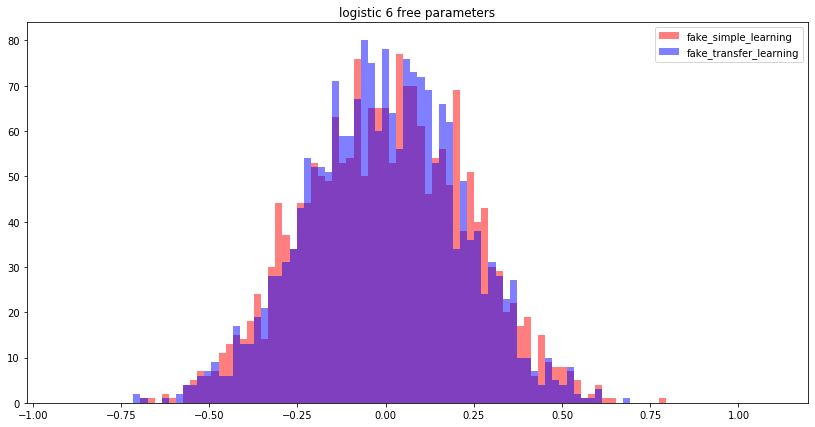

In [14]:
data=np.loadtxt('fake_6_params_data.dat')

pyplot.figure(figsize=(14, 7))

bins_data=pyplot.hist(data, bins=bins_real[1],color='red',label='fake_simple_learning', alpha=0.5)
bins_fake=pyplot.hist(x_fake.numpy(), bins=bins_real[1],color='blue', label='fake_transfer_learning', alpha=0.5)

print("KL DIVERGENCE:",kl_divergence(bins_data[0],bins_fake[0],epsilon=0.1))
pyplot.title('logistic 6 free parameters')
#pyplot.yscale('log')
pyplot.legend()
pyplot.show()

- problema galileo quando partono contemporaneamente



### 2 free parameters (8 fixed params)

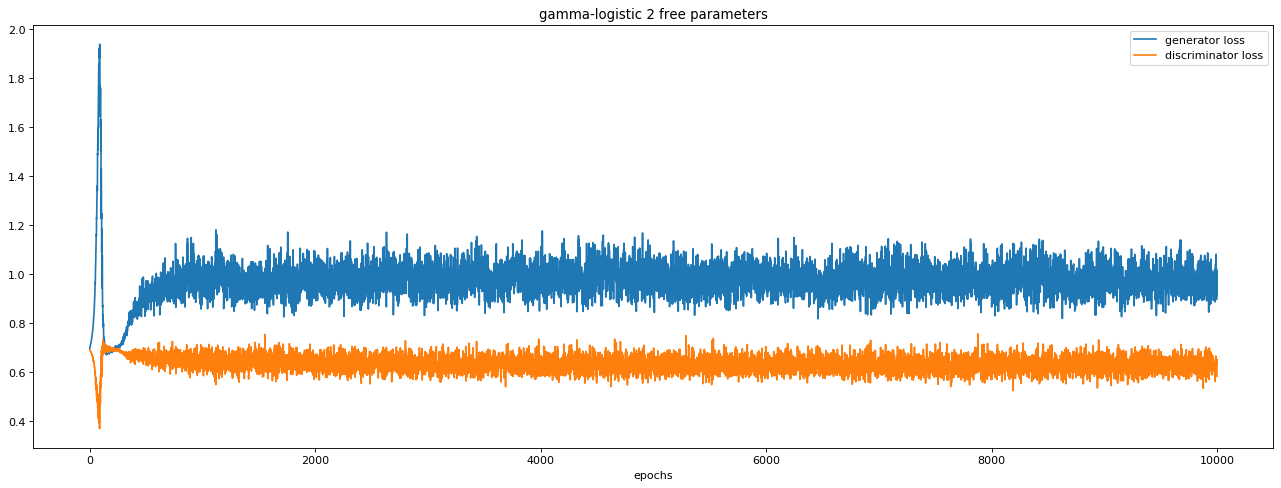

In [3]:
n_layers=128
d_loss = np.loadtxt(f"dloss_1Dgamma_1_3_2_10000_{n_layers}_0.1_fixed_params_8", delimiter=' ')
g_loss= np.loadtxt(f"gloss_1Dgamma_1_3_2_10000_{n_layers}_0.1_fixed_params_8", delimiter=' ')
g_loss=g_loss[:10000]
d_loss=d_loss[:10000]
pyplot.figure(figsize=(20, 7), dpi=80)
pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), g_loss, label='generator loss')
pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), d_loss, label='discriminator loss')
pyplot.title('gamma-logistic 2 free parameters')
pyplot.xlabel('epochs')
pyplot.legend()

pyplot.show()

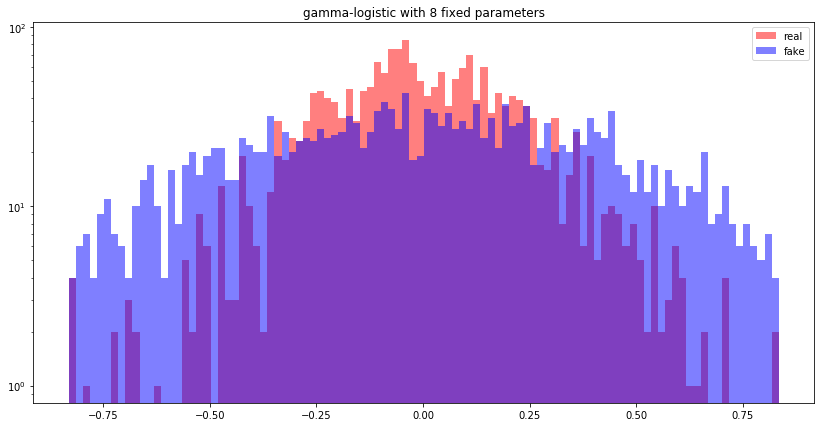

In [4]:
# number of qubits generator
nqubits = 1
# create hamiltonians
def hamiltonian1():
        m0 = hamiltonians.Z(1).matrix
        ham = hamiltonians.Hamiltonian(1, m0)
        return ham
    
hamiltonian1 = hamiltonian1()

latent_dim=3
samples=2000
nqubits=1
layers=2
# create quantum generator
circuit = models.Circuit(nqubits)
for l in range(layers):
    for q in range(nqubits):
        circuit.add(gates.RY(q, 0))
        circuit.add(gates.RZ(q, 0))
for q in range(nqubits):
    circuit.add(gates.RY(q, 0))  

params = np.loadtxt(f"PARAMS_1Dgamma_1_3_2_10000_{n_layers}_0.1_fixed_params_8", delimiter=' ', unpack='true')
params = tf.Variable(params)
#print(params)
x_fake, y_fake = qc.generate_fake_samples(params, latent_dim, samples, circuit, nqubits, layers, hamiltonian1)
#x_fake,_= qc2.generate_fake_samples(params, latent_dim, samples)
s=qc.generate_training_real_samples(samples)
x_real, y_real = qc.generate_real_samples(samples, s, 1000)

nbins=100
pyplot.figure(figsize=(14, 7))
bins_real=pyplot.hist(x_real, color='red', bins=nbins,label='real', alpha=0.5)
bins_fake=pyplot.hist(x_fake.numpy(), bins=bins_real[1],color='blue', label='fake', alpha=0.5)
#pyplot.xlim(-1,1)
pyplot.yscale('log')
pyplot.title('gamma-logistic with 8 fixed parameters')
pyplot.legend()
pyplot.show()

In [5]:
print("KL DIVERGENCE:",kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1))

KL DIVERGENCE: 0.3214541050120654


KL DIVERGENCE: 0.3010166359133728


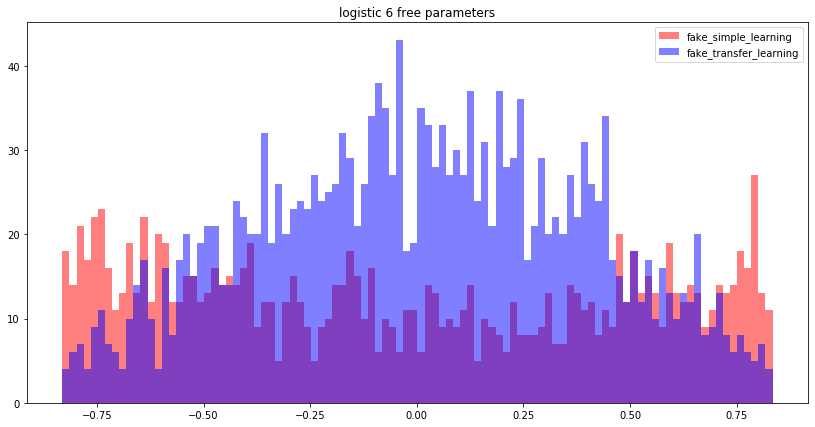

In [7]:
data=np.loadtxt('fake_data_2params.dat')

pyplot.figure(figsize=(14, 7))

bins_data=pyplot.hist(data, bins=bins_real[1],color='red',label='fake_simple_learning', alpha=0.5)
bins_fake=pyplot.hist(x_fake.numpy(), bins=bins_real[1],color='blue', label='fake_transfer_learning', alpha=0.5)

print("KL DIVERGENCE:",kl_divergence(bins_data[0],bins_fake[0],epsilon=0.1))
pyplot.title('logistic 6 free parameters')
#pyplot.yscale('log')
pyplot.legend()
pyplot.show()